In [21]:
import gc
import json
import random
import time
import warnings
from pathlib import Path
import catboost as cat
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from optuna.visualization.matplotlib import plot_optimization_history
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)

warnings.filterwarnings("ignore")

In [22]:
BASE_ARTIFACTS_DIR = Path("../artifacts")
SEED = 42

In [23]:
DATA_SPLIT_DIR = Path("../data/splits")
TARGET = "total_amount"

FP_TRAIN = DATA_SPLIT_DIR / "train.parquet"
FP_VAL = DATA_SPLIT_DIR / "val.parquet"
FP_TEST = DATA_SPLIT_DIR / "test.parquet"

# Load fitted preprocessing
preprocess = joblib.load(BASE_ARTIFACTS_DIR / "preprocess.joblib")

# Columns the transformer was fitted on
INPUT_COLS = []
for name, trans, cols in preprocess.transformers_:
    if name == "remainder":
        continue
    INPUT_COLS.extend(list(cols))

use_cols = sorted(set(INPUT_COLS + [TARGET]))
df_train = pd.read_parquet(FP_TRAIN, columns=use_cols)
df_val = pd.read_parquet(FP_VAL, columns=use_cols)
df_test = pd.read_parquet(FP_TEST, columns=use_cols)

X_train = preprocess.transform(df_train[INPUT_COLS])
X_val = preprocess.transform(df_val[INPUT_COLS])
X_test = preprocess.transform(df_test[INPUT_COLS])

y_train = df_train[TARGET].to_numpy()
y_val = df_val[TARGET].to_numpy()
y_test = df_test[TARGET].to_numpy()

print("Shapes:")
print("  X_train:", X_train_enc.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val_enc.shape, " y_val:  ", y_val.shape)
print("  X_test: ", X_test_enc.shape, " y_test: ", y_test.shape)
print("Done. Ready to model.")

Shapes:
  X_train: (1200000, 67)  y_train: (1200000,)
  X_val:   (210000, 67)  y_val:   (210000,)
  X_test:  (100000, 67)  y_test:  (100000,)
Done. Ready to model.


In [24]:
yhat_mean = np.full_like(y_val, y_train.mean(), dtype=float)

print("Baseline (mean predictor):")
print("  MAE :", mean_absolute_error(y_val, yhat_mean))
print("  RMSE:", root_mean_squared_error(y_val, yhat_mean))
print("  R²  :", r2_score(y_val, yhat_mean))

Baseline (mean predictor):
  MAE : 13.610531349429124
  RMSE: 19.78168598669016
  R²  : -0.006466287074264221


,Model,MAE,RMSE,R2,Fit_s,Pred_s
0,LightGBM,2.743,5.639,0.9182,28.16,1.39
1,XGBoost,2.721,5.643,0.9181,34.52,0.58
2,CatBoost,2.747,5.715,0.9160,117.87,3.87
3,Ridge(alpha=1.0),3.661,6.970,0.8751,1.28,0.04
4,LinearRegression,3.661,6.970,0.8751,4.93,0.04
5,MeanBaseline,13.611,19.782,-0.0065,0.00,0.01


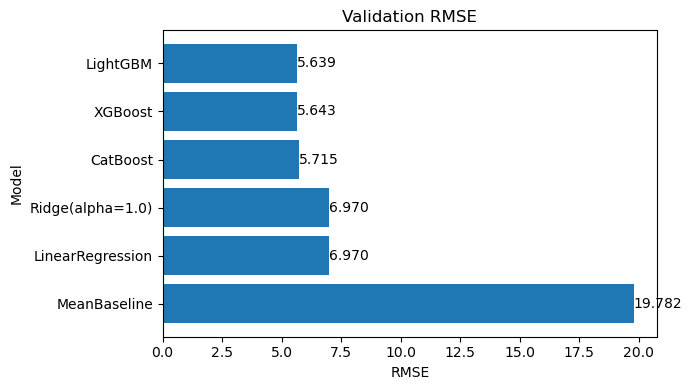

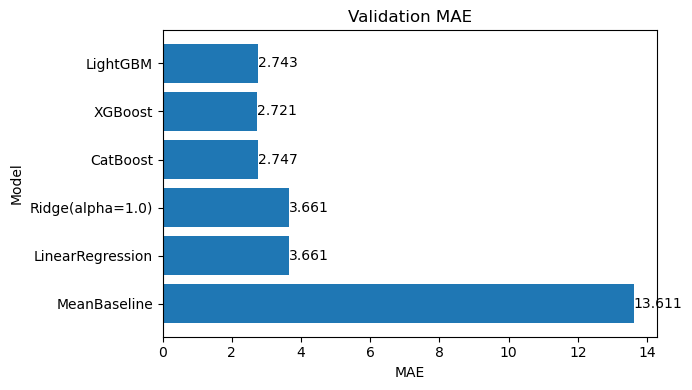


Best model (by RMSE): LightGBM
Artifacts saved in: ..\artifacts\model_experiments
Files: val_results.csv, val_results.json, val_rmse_bar.png, val_mae_bar.png


In [25]:
EXP_DIR = BASE_ARTIFACTS_DIR / "model_experiments"
EXP_DIR.mkdir(parents=True, exist_ok=True)


def fit_time_predict(name, est, Xtr, ytr, Xva, yva, is_baseline: bool = False):
    if is_baseline:
        t0 = time.time()
        yhat = np.full_like(yva, ytr.mean(), dtype=float)
        return dict(
            Model=name,
            MAE=mean_absolute_error(yva, yhat),
            RMSE=root_mean_squared_error(yva, yhat),
            R2=r2_score(yva, yhat),
            Fit_s=0.0,
            Pred_s=time.time() - t0,
        )

    t0 = time.time()
    est.fit(Xtr, ytr)
    fit_s = time.time() - t0

    t1 = time.time()
    yhat = est.predict(Xva)
    pred_s = time.time() - t1

    return dict(
        Model=name,
        MAE=mean_absolute_error(yva, yhat),
        RMSE=rmse(yva, yhat),
        R2=r2_score(yva, yhat),
        Fit_s=fit_s,
        Pred_s=pred_s,
    )


# Model configs
xgb_cfg = dict(
    objective="reg:squarederror",
    n_estimators=700,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=SEED,
    n_jobs=-1,
    verbosity=0,
)
lgb_cfg = dict(
    n_estimators=1200, learning_rate=0.05, random_state=SEED, n_jobs=-1, verbosity=-1
)
cat_cfg = dict(
    iterations=1200, learning_rate=0.05, depth=8, random_seed=SEED, verbose=False
)

models = [
    ("MeanBaseline", None, True),
    ("LinearRegression", LinearRegression(), False),
    ("Ridge", Ridge(alpha=1.0, random_state=42), False),
    ("XGBoost", xgb.XGBRegressor(**xgb_cfg), False),
    ("LightGBM", lgb.LGBMRegressor(**lgb_cfg), False),
    ("CatBoost", cat.CatBoostRegressor(**cat_cfg), False),
]

# Run evaluations
results = [
    fit_time_predict(n, e, X_train_enc, y_train, X_val_enc, y_val, is_baseline=b)
    for (n, e, b) in models
]

df_val = (
    pd.DataFrame(results).sort_values("RMSE", ascending=True).reset_index(drop=True)
)

display(
    df_val.style.format(
        {
            "MAE": "{:.3f}",
            "RMSE": "{:.3f}",
            "R2": "{:.4f}",
            "Fit_s": "{:.2f}",
            "Pred_s": "{:.2f}",
        }
    ).set_caption("Validation Performance")
)

# Charts
for metric, title, fname in [
    ("RMSE", "Validation RMSE", "val_rmse_bar.png"),
    ("MAE", "Validation MAE", "val_mae_bar.png"),
]:
    plt.figure(figsize=(7, 4))
    plt.barh(df_val["Model"], df_val[metric])
    plt.gca().invert_yaxis()
    for i, v in enumerate(df_val[metric]):
        plt.text(v, i, f"{v:.3f}", va="center")
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Model")
    plt.tight_layout()
    plt.savefig(EXP_DIR / fname, dpi=150)
    plt.show()

df_val.to_csv(EXP_DIR / "val_results.csv", index=False)

with open(EXP_DIR / "val_results.json", "w", encoding="utf-8") as f:
    json.dump(
        [
            {
                k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                for k, v in row.items()
            }
            for row in results
        ],
        f,
        indent=2,
    )

best_row = df_val.iloc[0]
best_name = best_row["Model"]
if best_name == "MeanBaseline" and len(df_val) > 1:
    best_row = df_val.iloc[1]
    best_name = best_row["Model"]

print("\nBest model (by RMSE):", best_name)
print("Artifacts saved in:", EXP_DIR)
print("Files: val_results.csv, val_results.json, val_rmse_bar.png, val_mae_bar.png")

[I 2025-09-23 10:16:55,461] A new study created in memory with name: lgbm_regression_optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-23 10:17:52,106] Trial 0 finished with value: 5.684682228705862 and parameters: {'n_estimators': 1500, 'learning_rate': 0.1667521176194013, 'num_leaves': 383, 'max_depth': 11, 'min_child_samples': 39, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'min_split_gain': 0.7080725777960455}. Best is trial 0 with value: 5.684682228705862.
[I 2025-09-23 10:18:45,079] Trial 1 finished with value: 5.673878722523198 and parameters: {'n_estimators': 500, 'learning_rate': 0.17898794163735265, 'num_leaves': 447, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'reg_alpha': 0.00052821153945323, 'reg_lambda': 7.71800699380605e-05, 'min_split_gain': 0.2912291401980419}. Best is trial 1 with value: 5.673878722523198.
[I 2025-09-23 10:24:48,863] Trial 2 finished with value: 5.655701067303334 and parameters: {'n_estimators': 2000, 'learni

<Figure size 640x480 with 0 Axes>

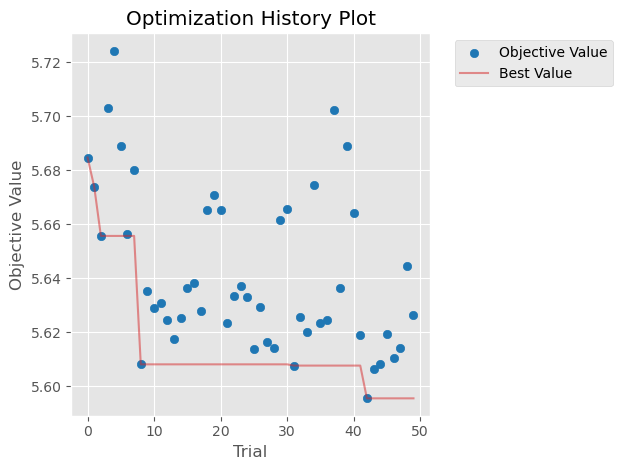

In [5]:
N_TRIALS = 50
EARLY_STOPPING_ROUNDS = 200
TIMEOUT = None
EXP_DIR = BASE_ARTIFACTS_DIR / "model_experiments" / "optuna_lgbm"
EXP_DIR.mkdir(parents=True, exist_ok=True)
STUDY_NAME = "lgbm_regression_optimization"

np.random.seed(SEED)
random.seed(SEED)

# Study
sampler = optuna.samplers.TPESampler(seed=SEED)

study = optuna.create_study(
    direction="minimize",
    study_name=STUDY_NAME,
    sampler=sampler,
)


# Objective
def objective(trial: optuna.trial.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000, step=250),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 511, step=32),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "random_state": SEED,
        "n_jobs": 1,
        "feature_fraction_seed": SEED,
        "bagging_seed": SEED,
        "data_random_seed": SEED,
        "verbosity": -1,
    }

    model = lgb.LGBMRegressor(**params)

    callbacks = [lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]

    model.fit(
        X_train_enc,
        y_train,
        eval_set=[(X_val_enc, y_val)],
        eval_metric="rmse",
        callbacks=callbacks,
    )

    preds = model.predict(X_val_enc)
    score = root_mean_squared_error(y_val, preds)
    trial.set_user_attr("valid_rmse", score)

    del model
    gc.collect()

    return score


# Optimize
study.optimize(
    objective,
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
    n_jobs=1,
    show_progress_bar=True,
    gc_after_trial=True,
)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

# Save: best params (JSON)
(EXP_DIR / "best_params.json").write_text(json.dumps(study.best_params, indent=2))


# Save: trials.json
def trial_to_dict(t: optuna.trial.FrozenTrial):
    return {
        "number": t.number,
        "value": t.value,
        "state": str(t.state),
        "params": t.params,
        "user_attrs": t.user_attrs,
        "duration": t.duration.total_seconds() if t.duration else None,
        "datetime_start": t.datetime_start.isoformat() if t.datetime_start else None,
        "datetime_complete": (
            t.datetime_complete.isoformat() if t.datetime_complete else None
        ),
    }


with (EXP_DIR / "trials.json").open("w") as f:
    json.dump([trial_to_dict(t) for t in study.trials], f, indent=2)

# Plot optimization history
plt.figure()
plot_optimization_history(study)
plt.tight_layout()
plt.savefig(EXP_DIR / "optimization_history.png", dpi=150)
plt.show()

In [26]:
EXP_DIR = BASE_ARTIFACTS_DIR / "model_experiments" / "final_eval"
EXP_DIR.mkdir(parents=True, exist_ok=True)
params_path = ARTIFACTS_DIR / "model_experiments" / "optuna_lgbm" / "best_params.json"
model_path = EXP_DIR / "model.joblib"
metrics_json_path = EXP_DIR / "metrics.json"
metrics_txt_path = EXP_DIR / "metrics.txt"
pred_path = EXP_DIR / "y_test_pred.npy"

# Load best params
with open(params_path, "r", encoding="utf-8") as f:
    best_params = json.load(f)
best_params.update({"random_state": SEED, "n_jobs": -1, "verbosity": -1})

# Train final model on TRAIN + VAL
final_model = lgb.LGBMRegressor(**best_params)
X_trval = np.concatenate([X_train_enc, X_val_enc], axis=0)
y_trval = np.concatenate([y_train, y_val], axis=0)

final_model.fit(X_trval, y_trval)

# Predict on TEST
y_pred = final_model.predict(X_test_enc)
test_rmse = rmse(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("Test results (2025-07):")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   MAE : {test_mae:.4f}")
print(f"   R²  : {test_r2:.4f}")

joblib.dump(final_model, model_path)

metrics = {
    "split": "TEST",
    "rmse": float(test_rmse),
    "mae": float(test_mae),
    "r2": float(test_r2),
    "model_path": str(model_path),
    "params_path": str(params_path),
}

with open(metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

Test results (2025-07):
   RMSE: 5.6032
   MAE : 2.9456
   R²  : 0.9209
